### Make required imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from sklearn.model_selection import train_test_split
from interpret import show
from interpret import data
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf

warnings.filterwarnings("ignore")
cos_site = 'cgo'
cos_target = 'COS_' + cos_site

### Build out file hierarchy

In [2]:
results_path = './Results'
if not os.path.isdir(results_path):
    os.mkdir(results_path)

site_path = './Results/' + cos_site + '_Results'
if not os.path.isdir(site_path):
    # directory for this target site does not exist, so we need to make it
    os.mkdir(site_path)
performance_path = './Results/' + cos_site + '_Results/Performance'

if not os.path.isdir(performance_path):
    os.mkdir(performance_path)
    
yearly_path = performance_path + '/Yearly'
if not os.path.isdir(yearly_path):
    os.mkdir(yearly_path)
    
shape_path = './Results/' + cos_site + '_Results/Shape_Functions'

if not os.path.isdir(shape_path):
    os.mkdir(shape_path)


### Load dataframe and separate feature and target sets

In [3]:
df = pd.read_pickle('COS_Seesaw_dataframe_' + cos_site + '.pkl')
# print(df)
columns = list(df.columns)
if cos_target in columns:
    columns.remove(cos_target)
else:
    print('Error, target column not in dataframe')
    quit()
    
x = df[columns]
y = df[cos_target]

### Make test train split, random seed is to ensure consistent results on multiple runs
### change  seed value to get different split

In [4]:
seed = 3
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

# set up for predicted vs actual plot
# sorting the test set should not matter since we are not using it to train
X_test = X_test.sort_index()
y_test = y_test.sort_index()

test_time = X_test['time']
# divide test set by year and save for later
start = X_test['time'].min().year
end = X_test['time'].max().year
test_by_year = []

for year in range(start, (end + 1)):
    year_X = X_test[X_test['time'].dt.year == year]
    year_y = y_test.where(y_test.index.isin(year_X.index))
    
    year_y.dropna(inplace=True)
    year_time = year_X['time']
    year_X.drop(axis=1, labels='time', inplace=True)
    year_data = (year, year_time, year_X, year_y)
    test_by_year.append(year_data)

# print(test_by_year)

X_test.drop(axis=1, labels='time', inplace=True)

#drop time in X_train
X_train.drop(axis=1, labels='time', inplace=True)

### Show Marginal

In [5]:
marginal = data.Marginal()
marginal_explanation = marginal.explain_data(X_train, y_train)
show(marginal_explanation)

<!-- http://127.0.0.1:7001/140383160079888/ -->

### Train Models

In [6]:
ebm = ExplainableBoostingRegressor(random_state=seed, interactions=15)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['cos_mean-1y', 'SO_vwnd',
                                            'SO_vwnd-15d', 'SO_vwnd-1m',
                                            'SO_vwnd-1m15d', 'SO_vwnd-2m',
                                            'AO_vwnd', 'AO_vwnd-15d',
                                            'AO_vwnd-1m', 'AO_vwnd-1m15d',
                                            'AO_vwnd-2m', 'NEP_vwnd',
                                            'NEP_vwnd-15d', 'NEP_vwnd-1m',
                                            'NEP_vwnd-1m15d', 'NEP_vwnd-2m',
                                            'NWP_vwnd', 'NWP_vwnd-15d',
                                            'NWP_vwnd-1m', 'NWP_vwnd-1m15d',
                                            'NWP_vwnd-2m', 'EQNEP_vwnd',
                                            'EQNE...
                                            'continuous', 'continuous',
                                            'continuous', 'continuou

### What model learned

In [7]:
ebm_global = ebm.explain_global(name='EBM')

### Explanation of individul prediction

In [8]:
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')

### Evaluate performance

In [9]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')

### Everything at once

In [10]:
show([marginal_explanation, ebm_global, ebm_perf, ebm_local])

<!-- http://127.0.0.1:7001/140382405929280/ -->
 Open in new window

### Save all the shape graphs

In [11]:

# need to figure out how to save importance plot
for index, value in enumerate(ebm.feature_groups_):
    feature_name = ebm_global.feature_names[index]
    path = shape_path + "/" + feature_name + ".png"
    plotly_fig = ebm_global.visualize(index)
    plotly_fig.write_image(path)

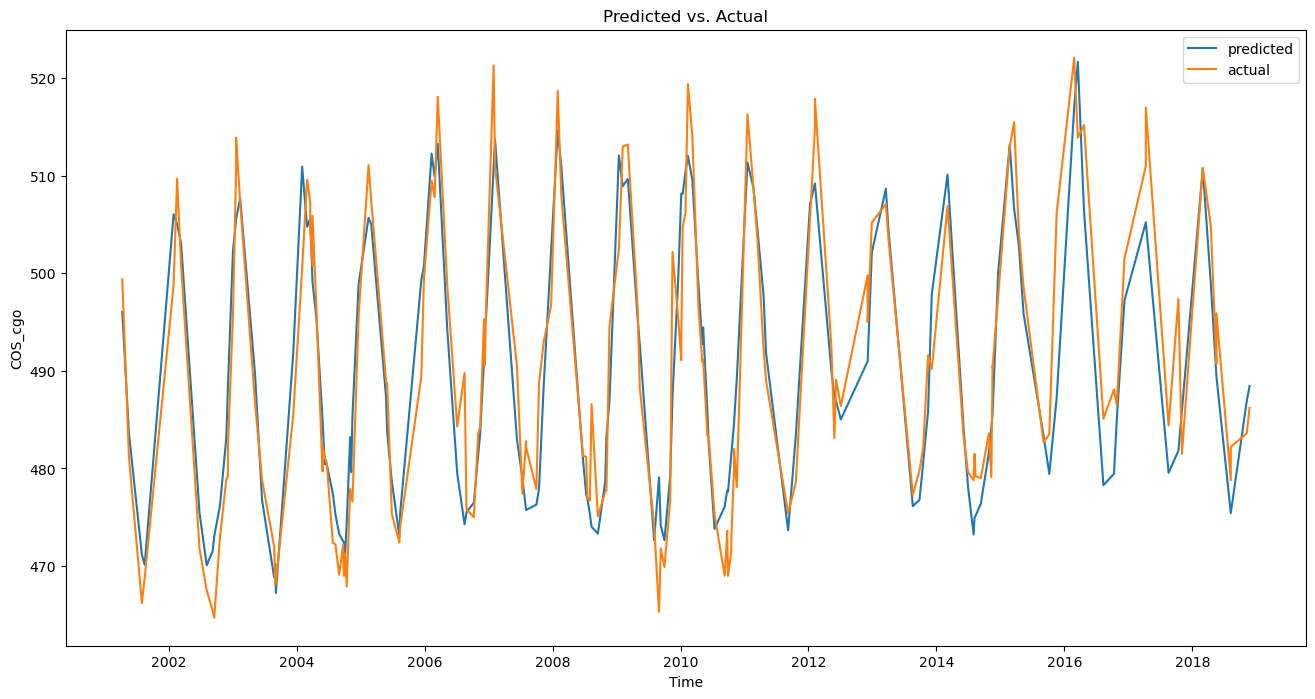

In [12]:
predicted = ebm.predict(X_test)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test_time, predicted, '-',  label='predicted')
ax.plot(test_time, y_test, '-', label='actual')
ax.set_title("Predicted vs. Actual")
ax.set_xlabel('Time')
ax.set_ylabel(cos_target)
plt.legend()
plt.show()
fig.savefig(performance_path + '/predictedVsActual.png')

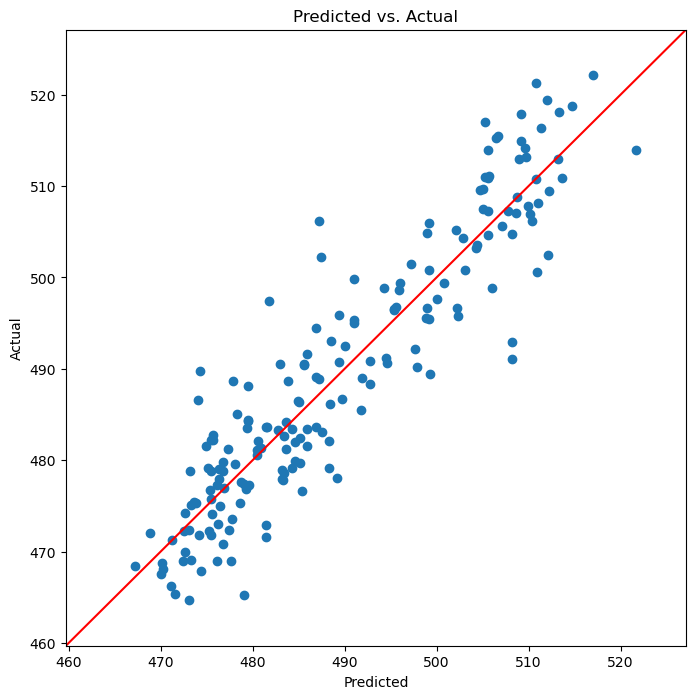

In [13]:
axis_min = min(y_test.min(), min(predicted)) - 5 # pad by 5
axis_max = max(y_test.max(), max(predicted)) + 5 # pad by 5
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(predicted, y_test)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Predicted vs. Actual')
ax.plot([0,1],[0,1], color='red', transform=ax.transAxes)
ax.set_xlim([axis_min, axis_max])
ax.set_ylim([axis_min, axis_max])
plt.show()
fig.savefig(performance_path + '/predictedVsActual_scatter.png')

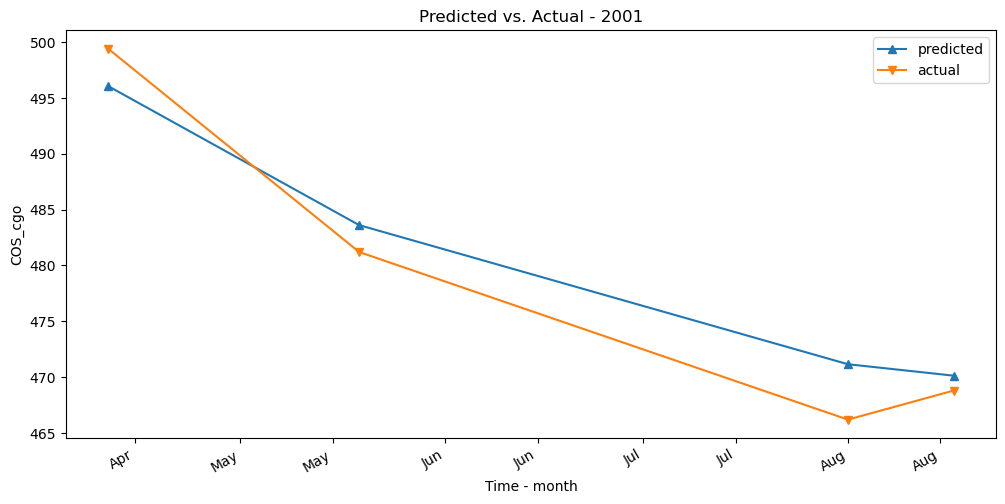

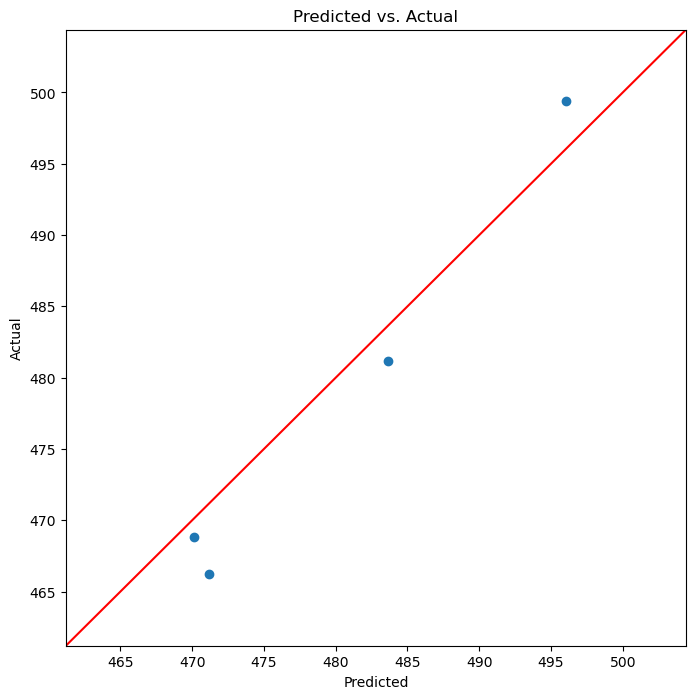

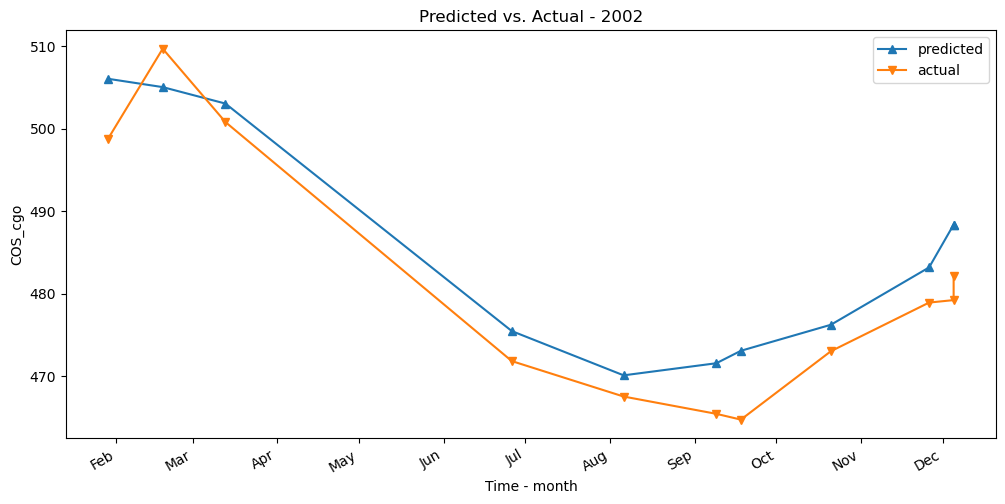

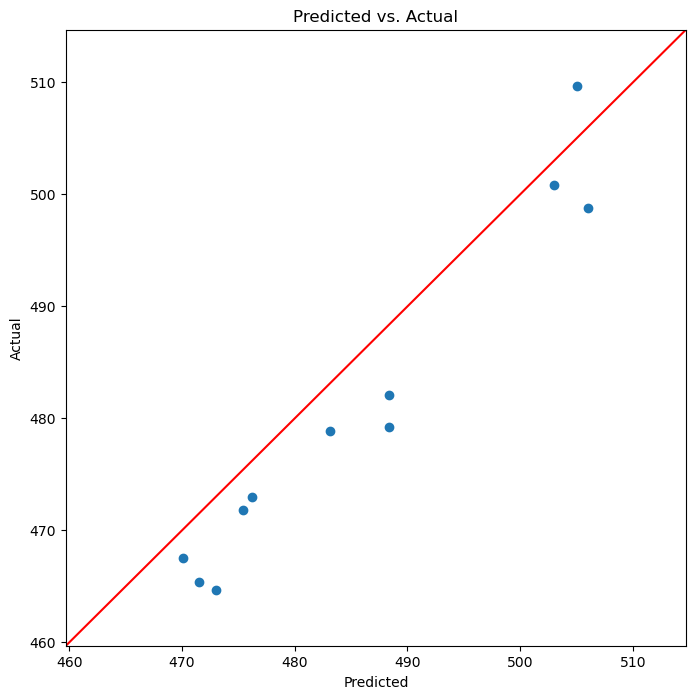

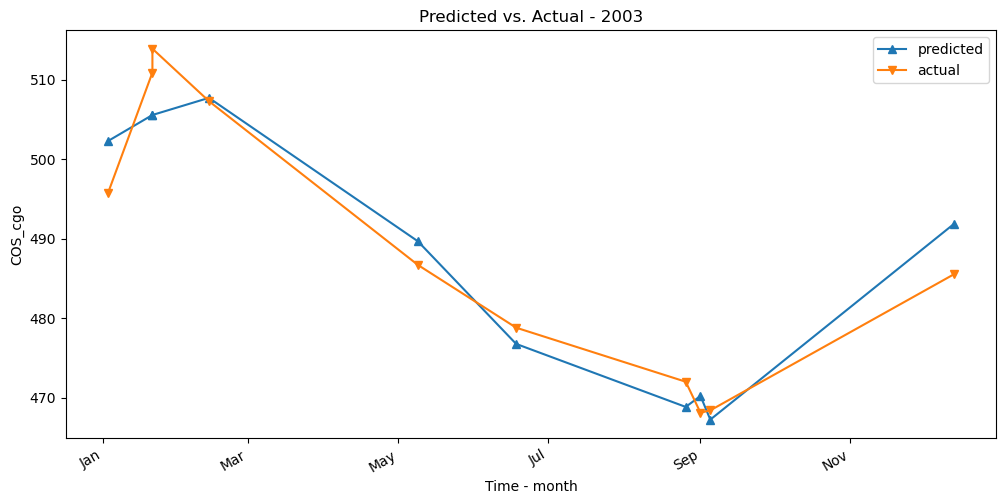

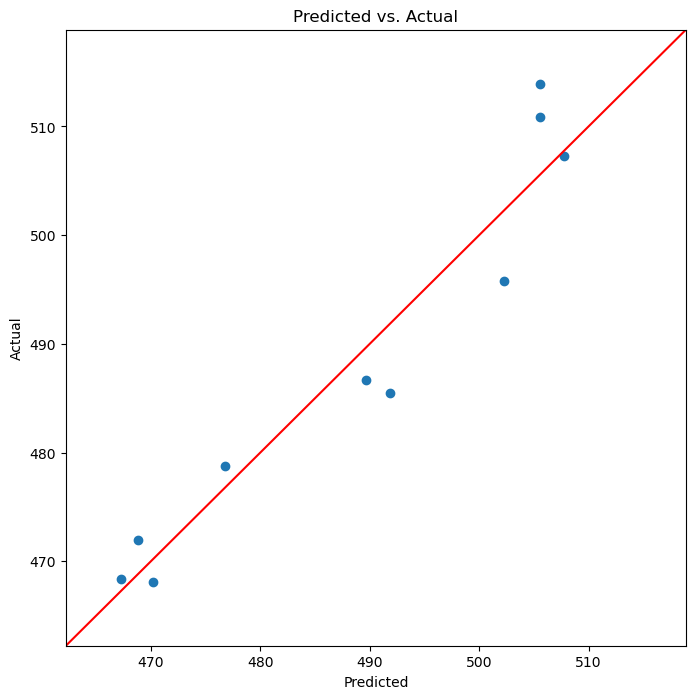

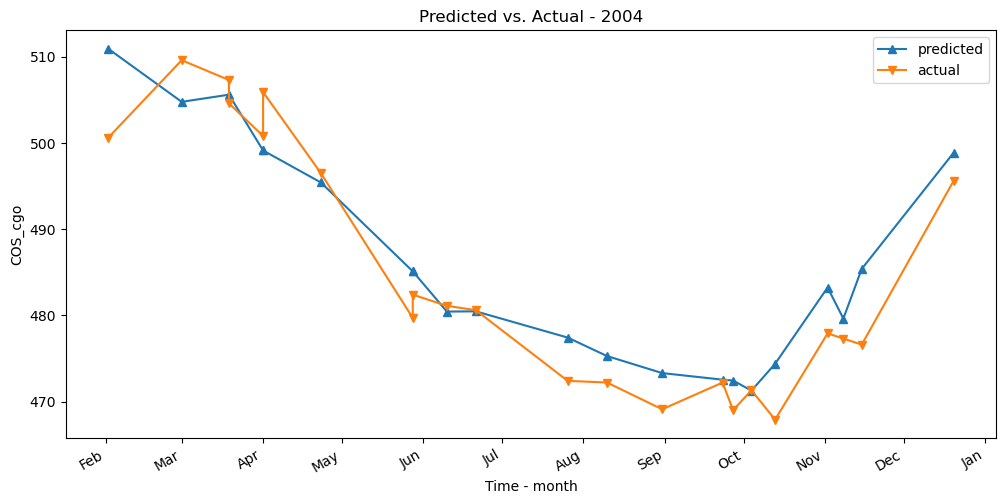

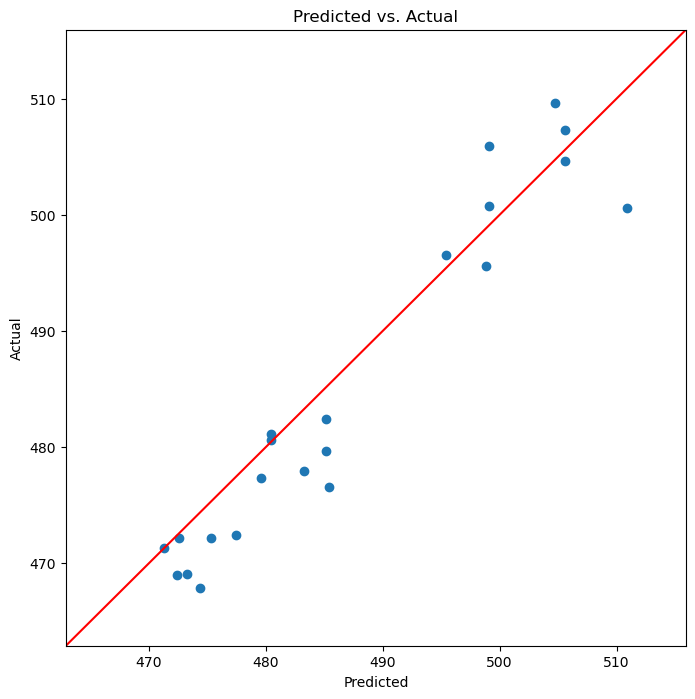

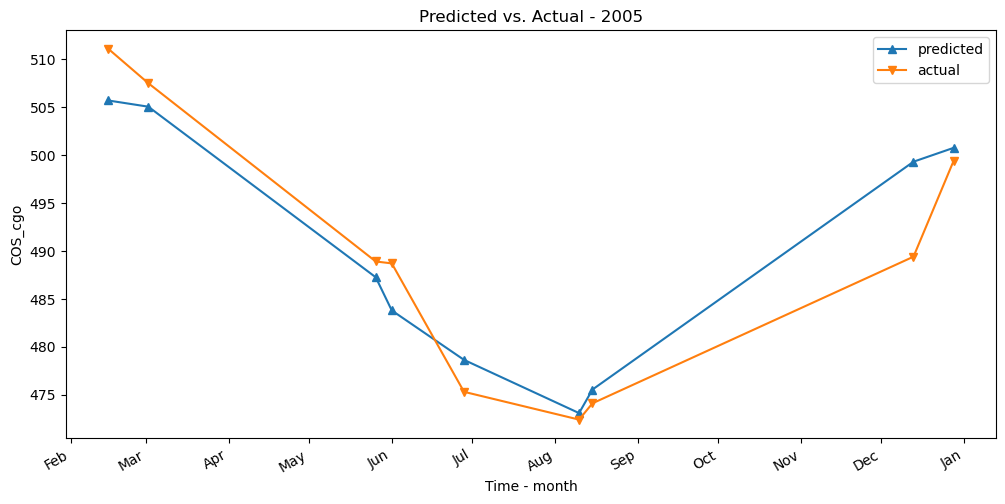

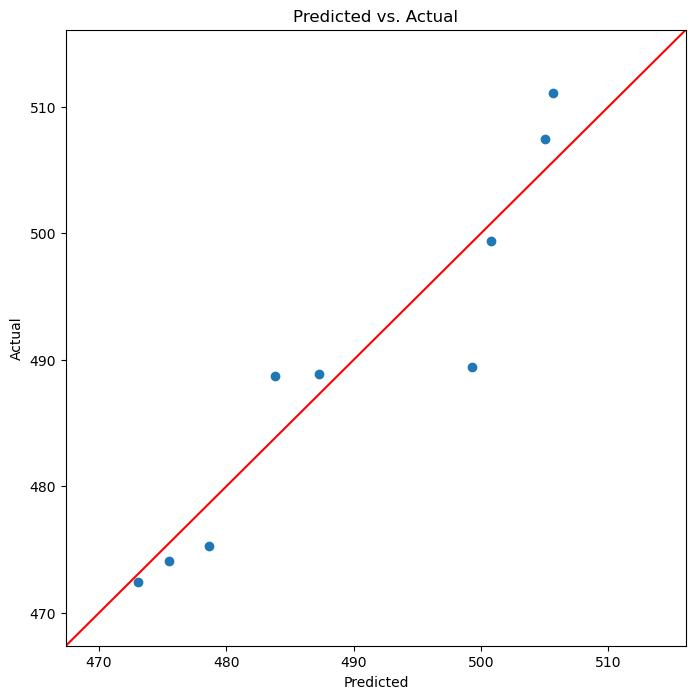

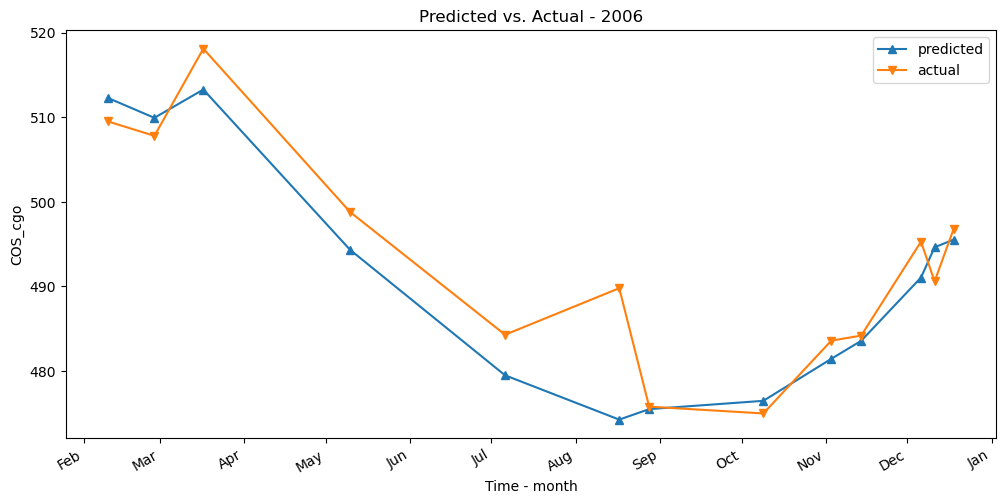

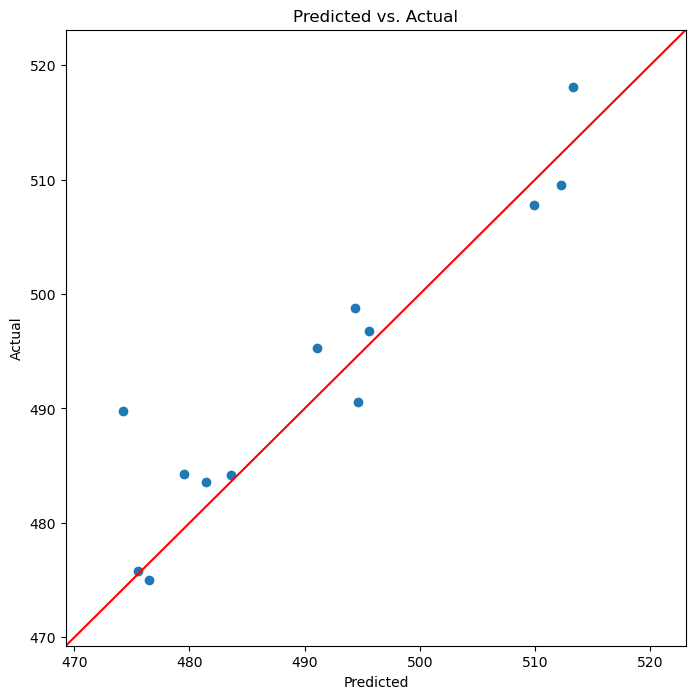

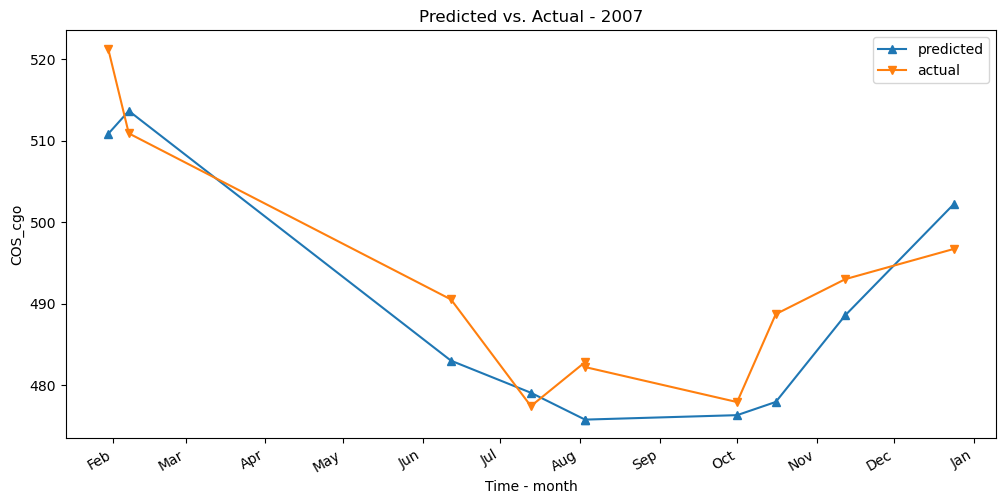

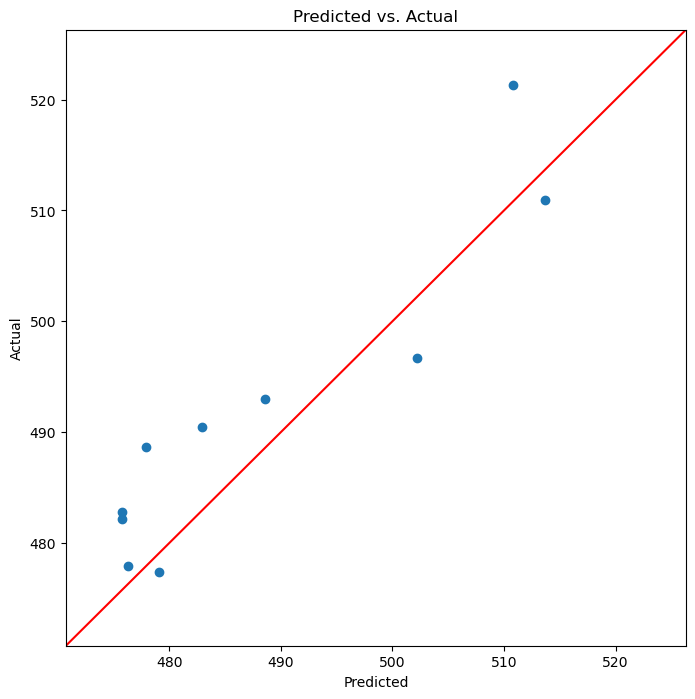

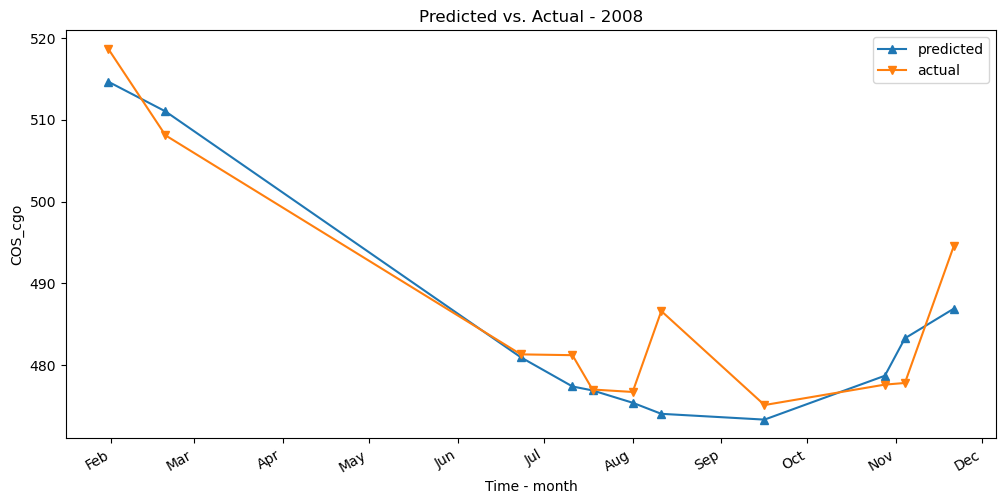

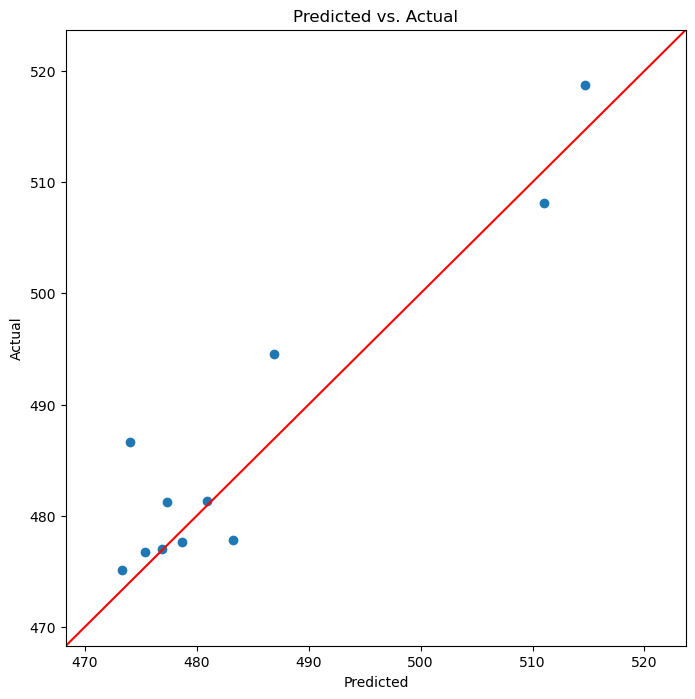

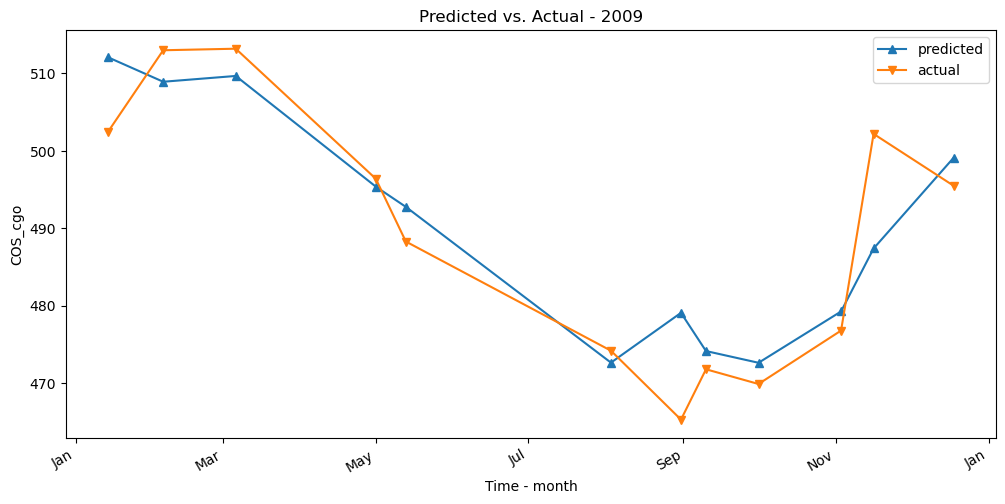

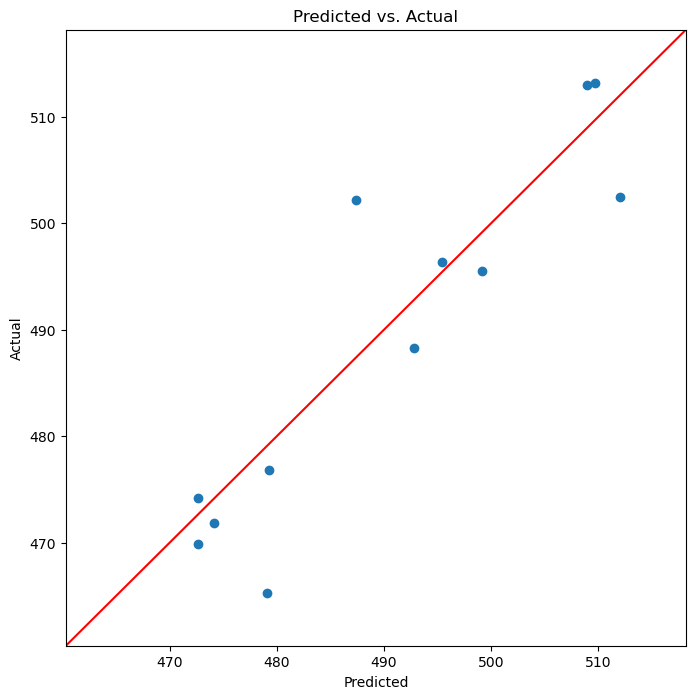

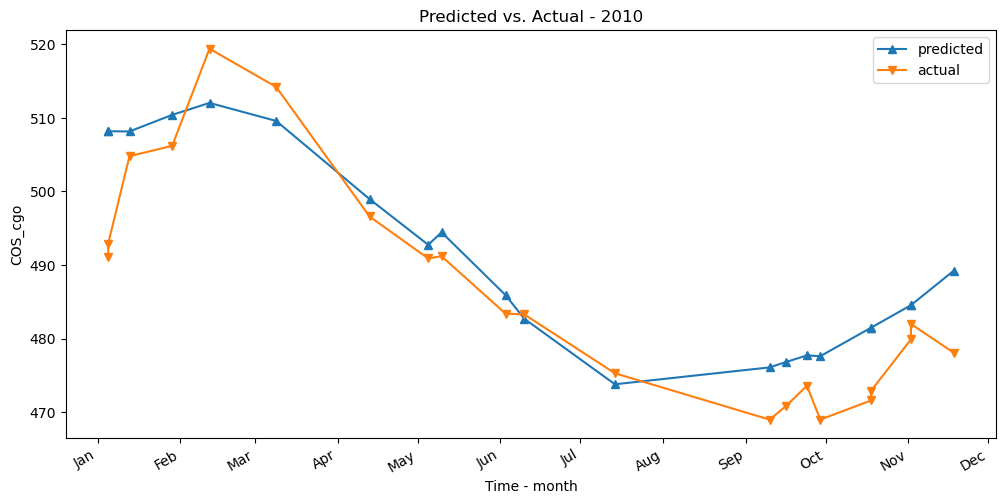

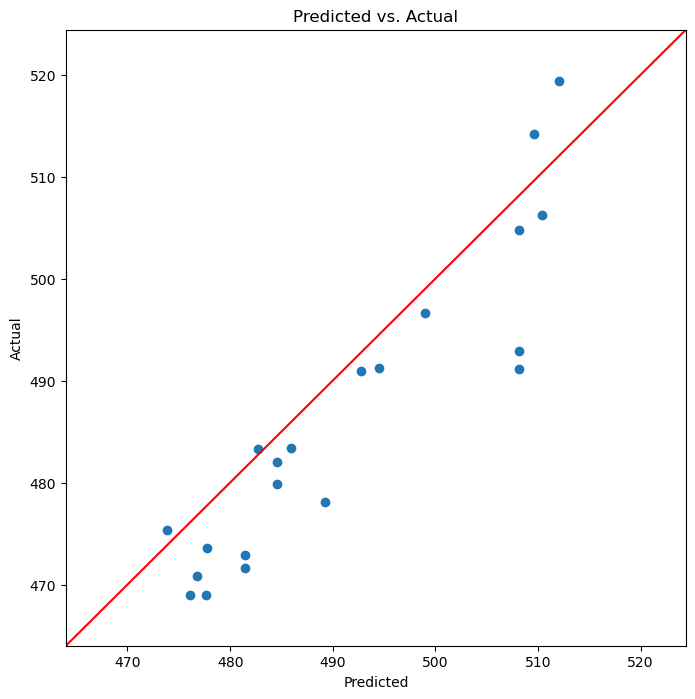

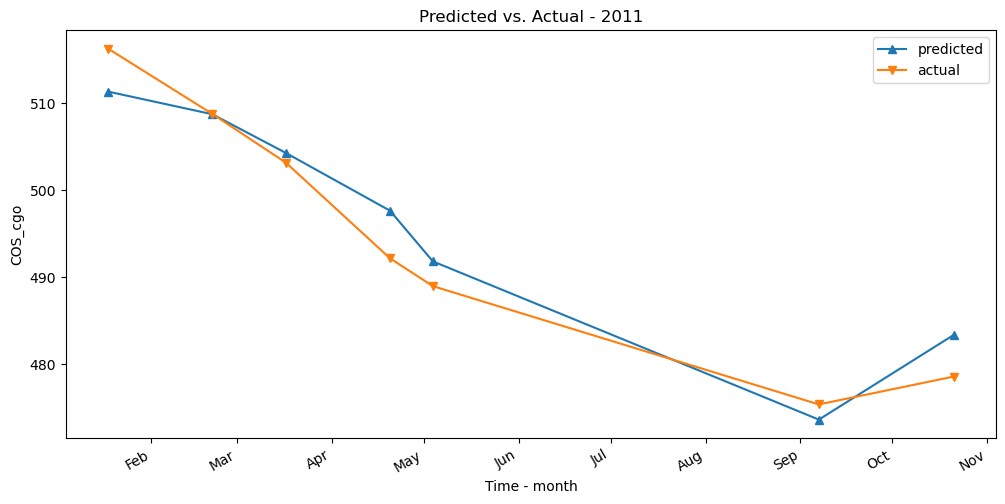

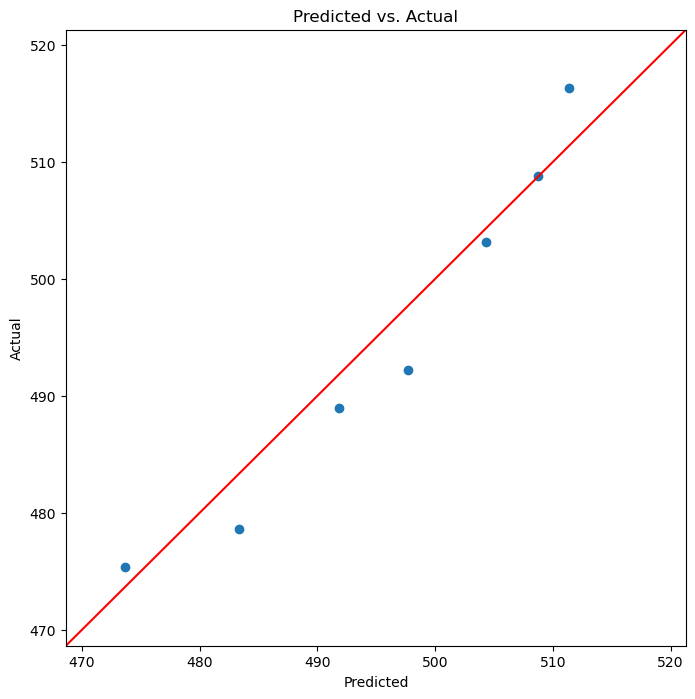

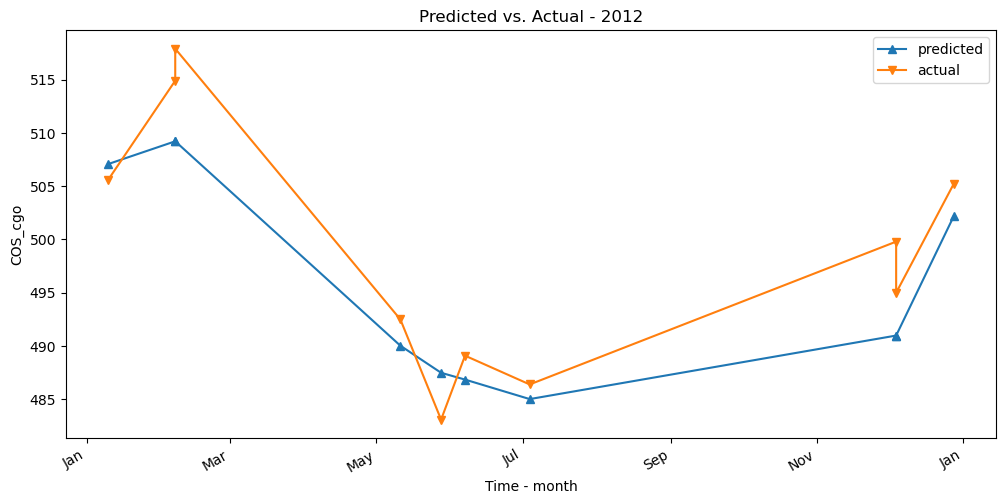

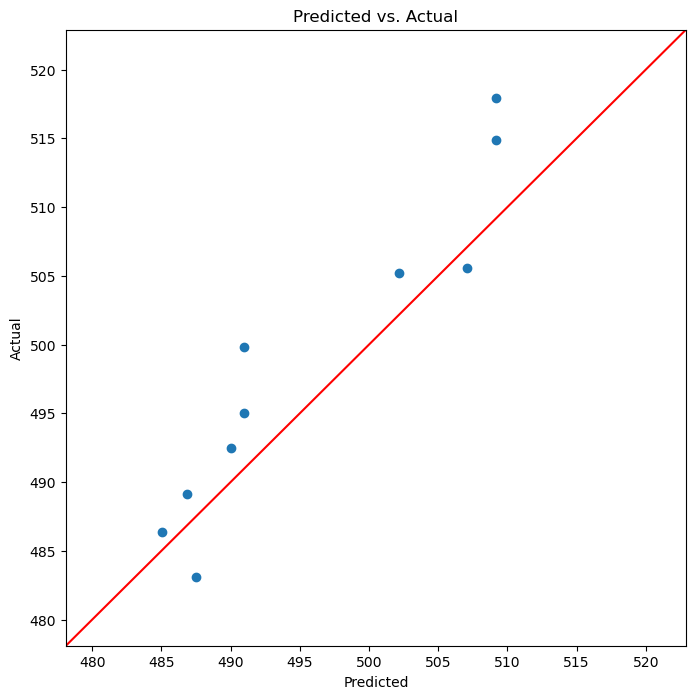

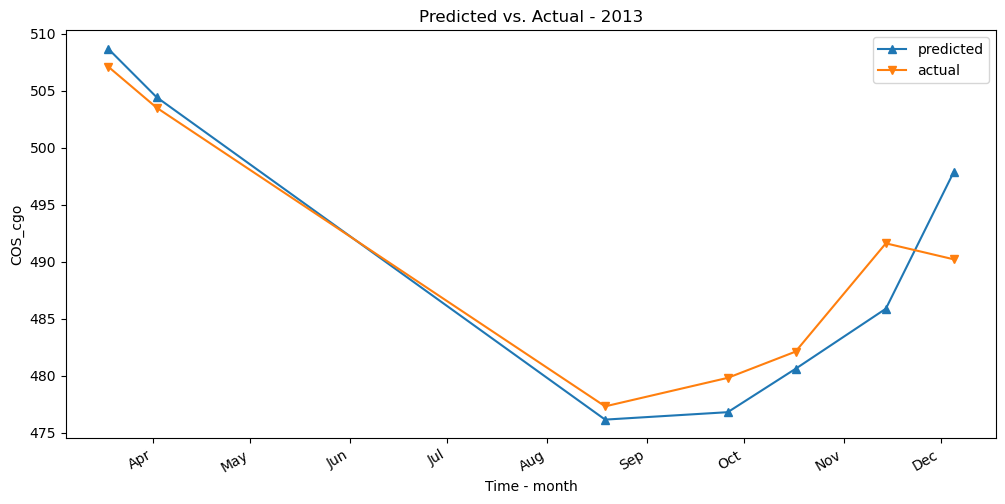

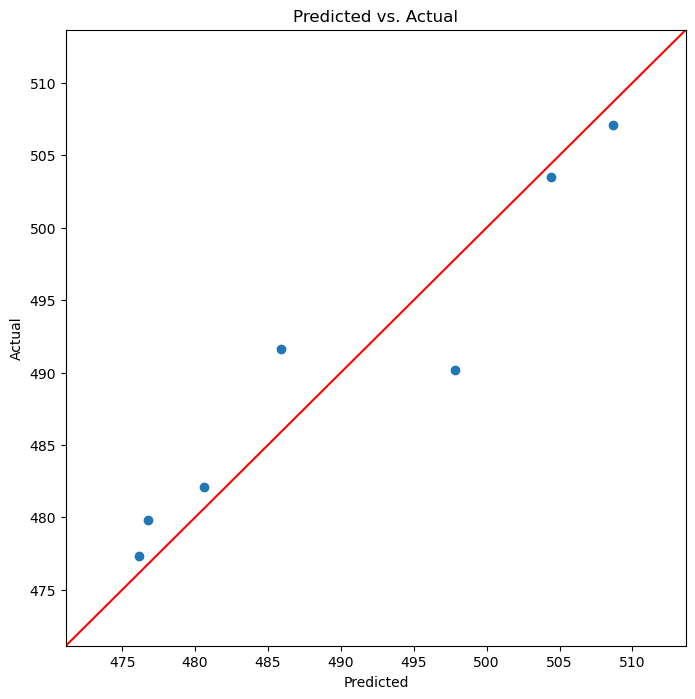

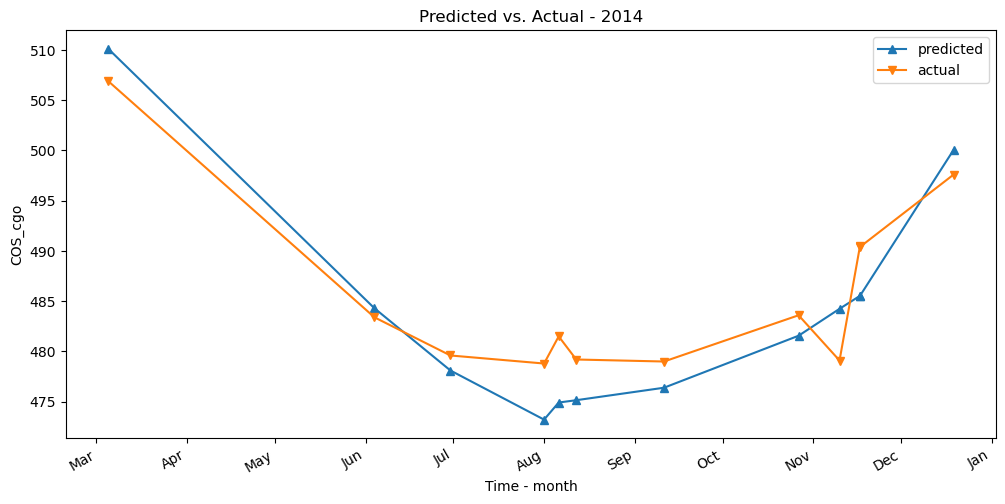

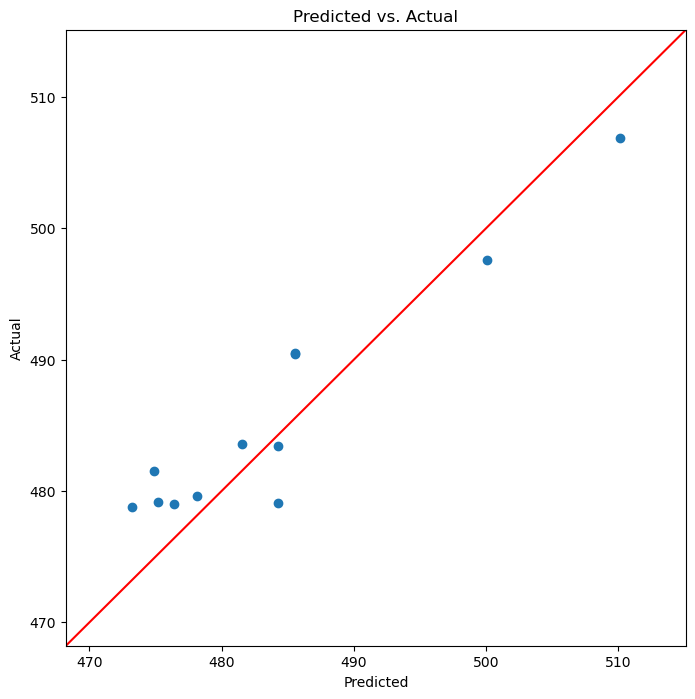

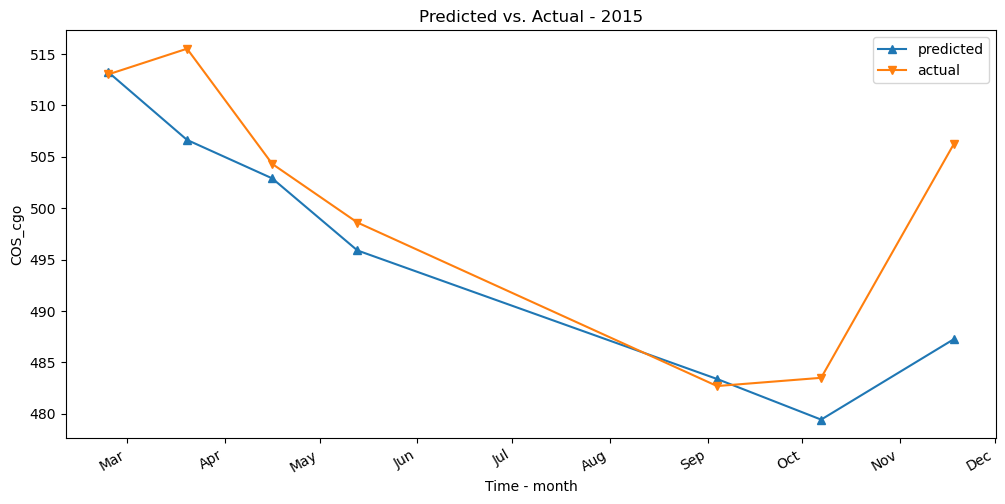

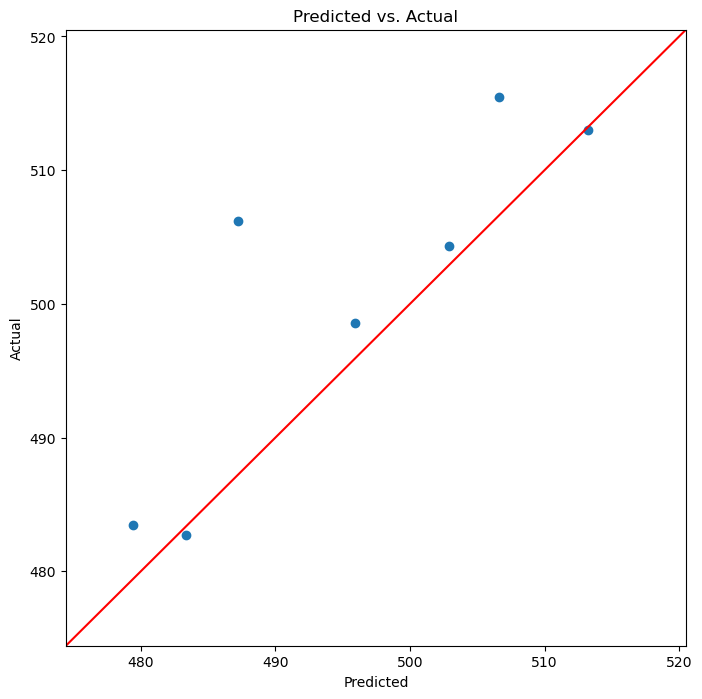

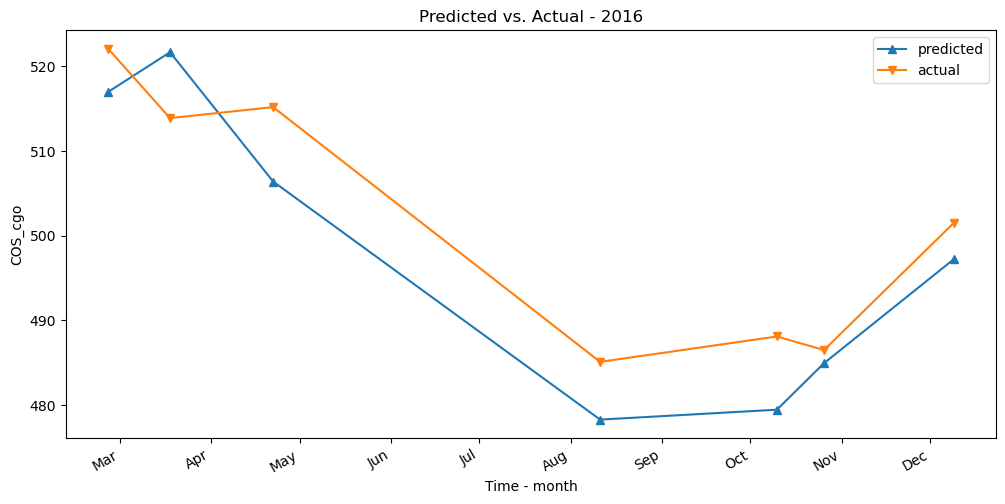

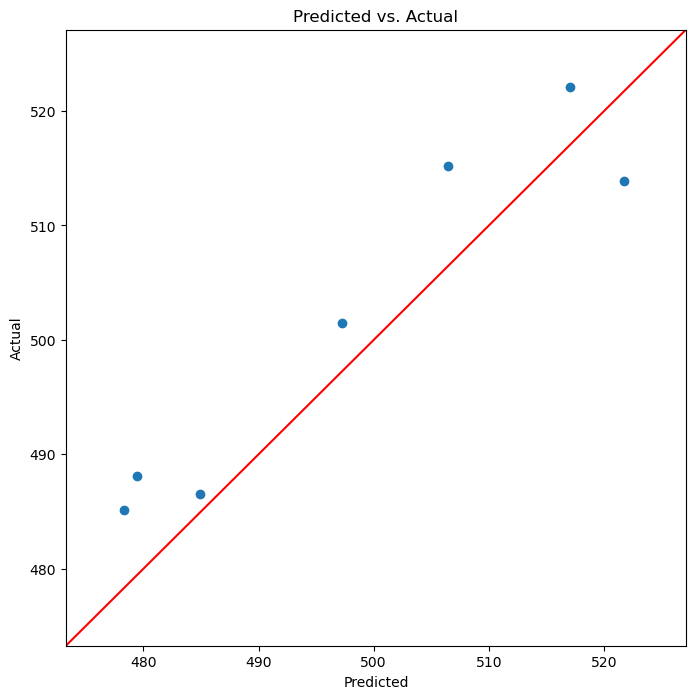

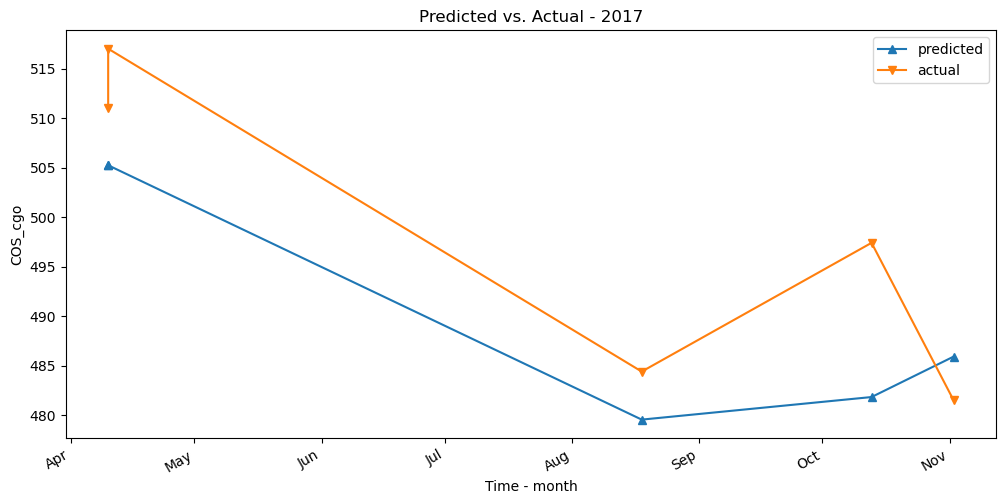

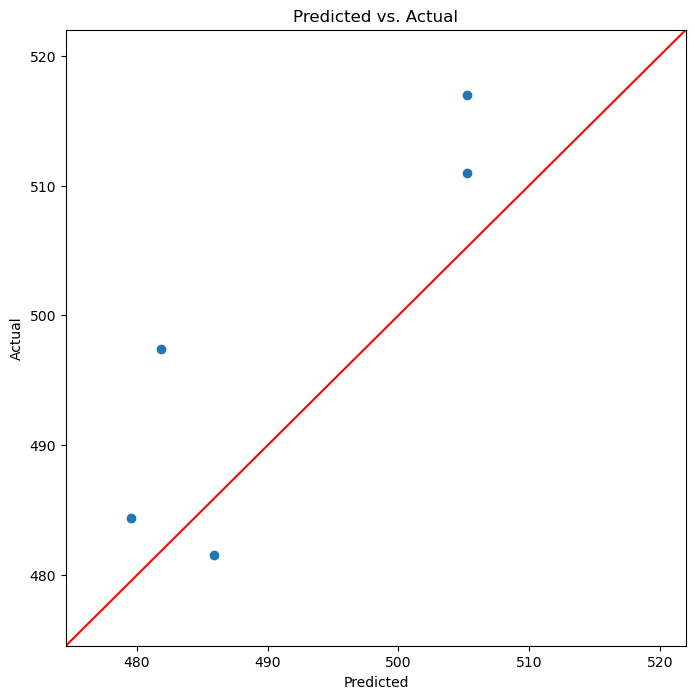

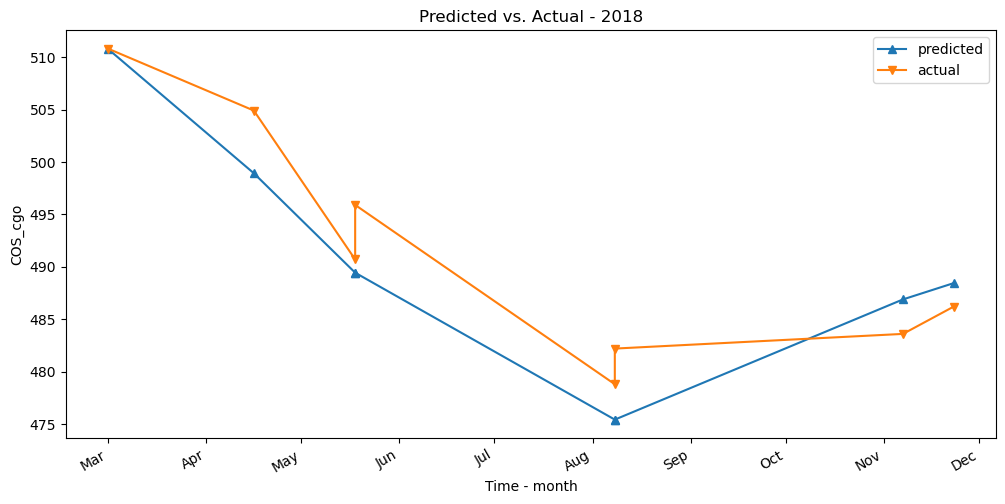

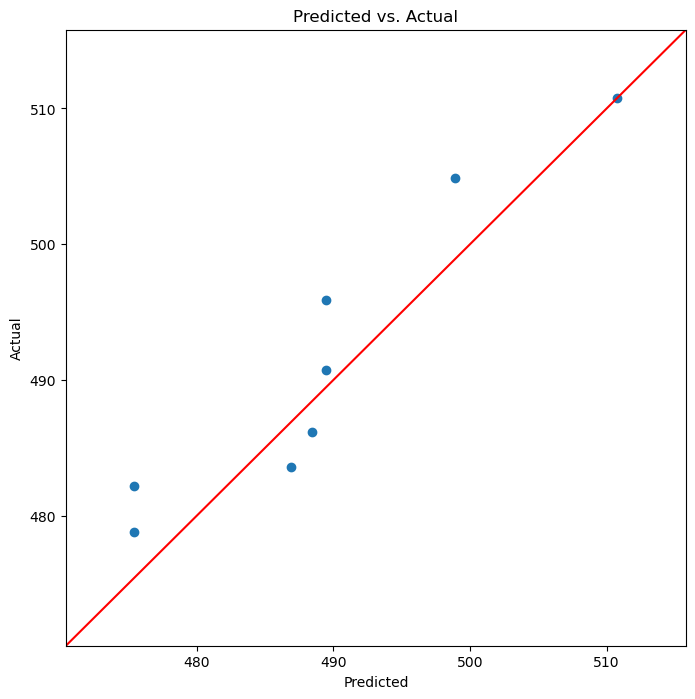

In [14]:
import math
rmse_dict = {'year' : [], 'rmse': []}
for year in test_by_year:
    predicted = ebm.predict(year[2])
    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(year[1], predicted, '-^', label='predicted')
    ax.plot(year[1], year[3], '-v',label='actual')
    ax.set_title('Predicted vs. Actual - ' + str(year[0]))
    ax.set_xlabel('Time - month')
    ax.set_ylabel(cos_target)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.legend()
    plt.show()
    fig_name = str(year[0]) + '-pVSa.png'
    fig.savefig(yearly_path + '/' + fig_name)
    
    axis_min = min(year[3].min(), min(predicted)) - 5 # pad by 5
    axis_max = max(year[3].max(), max(predicted)) + 5 # pad by 5
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(predicted, year[3])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Predicted vs. Actual')
    ax.plot([0,1],[0,1], color='red', transform=ax.transAxes)
    ax.set_xlim([axis_min, axis_max])
    ax.set_ylim([axis_min, axis_max])
    plt.show()
    fig_name = str(year[0]) + '-pVSa_scatter.png'
    fig.savefig(yearly_path + '/' + fig_name)
    
    
    mse = np.square(np.subtract(predicted, year[3])).mean()
    rmse = math.sqrt(mse)
    rmse_dict['year'].append(str(year[0]))
    rmse_dict['rmse'].append(rmse)
    

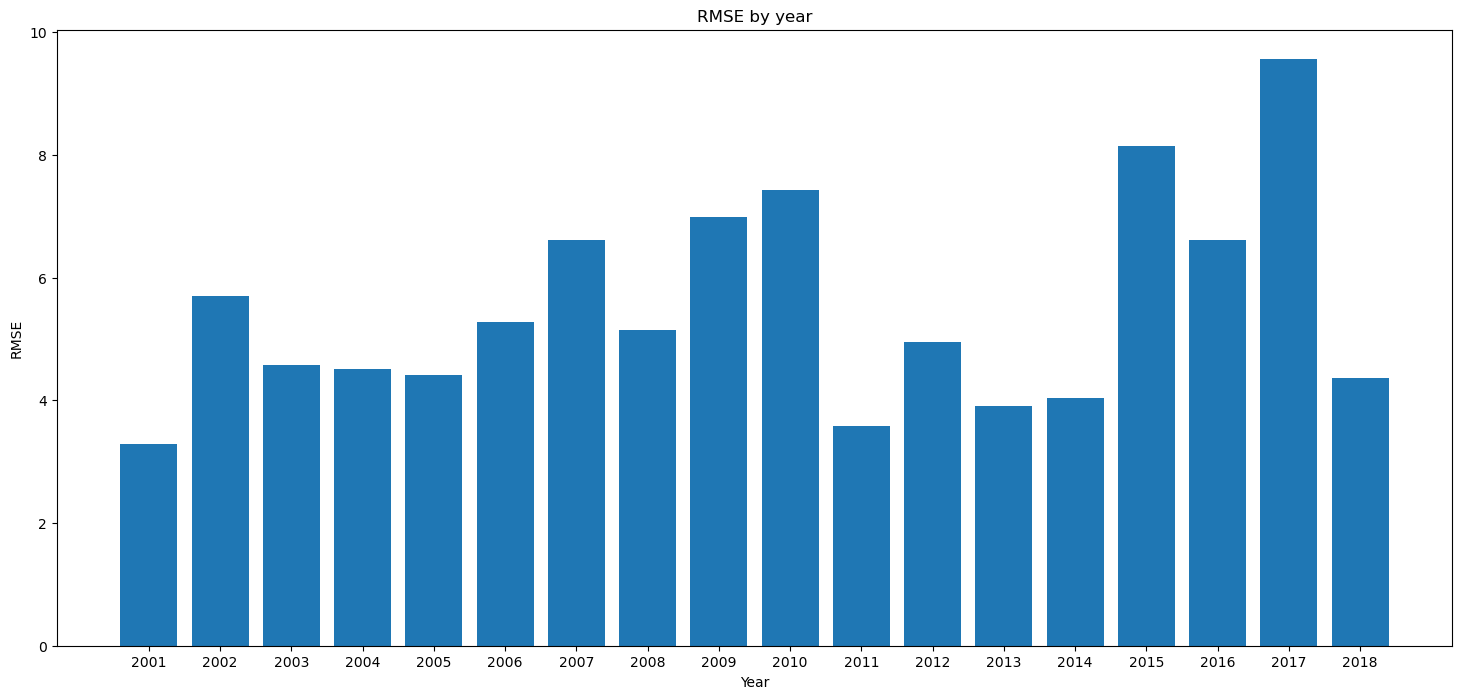

In [15]:
fig, ax = plt.subplots(figsize=(18,8))
ax.bar(rmse_dict['year'], rmse_dict['rmse'])
ax.set_xlabel('Year')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by year')
plt.show()
fig.savefig(performance_path + '/RMSE_Yearly.png')

In [16]:
# print(rmse_dict['year'])
# print(rmse_dict['rmse'])
rmse_sum = sum(rmse_dict['rmse'])
rmse_mean = rmse_sum / len(rmse_dict['rmse'])

sum_squared_diff = 0

for val in rmse_dict['rmse']:
    squared_diff = (val - rmse_mean) ** 2
    sum_squared_diff += squared_diff
variance = sum_squared_diff / len(rmse_dict['rmse'])
print('RMSE Variance = ' +str(variance))
std_deviation = math.sqrt(variance)
print('RMSE Standard Deviation = ' + str(std_deviation))
#print (sum(rmse_dict['rmse']))
#print(len(rmse_dict['rmse']))


RMSE Variance = 2.773064872208439
RMSE Standard Deviation = 1.6652521947766468
